In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0, '../')

In [3]:
from fastpm import core
import numpy
from fastpm.core import leapfrog

from pmesh.pm import ParticleMesh
from nbodykit.cosmology import Planck15
from kdcount import KDTree

In [52]:
from fastpm import core
class Solver(core.Solver):
    def __init__(self, pm, B=2):
        fpm = ParticleMesh(Nmesh=pm.Nmesh * B, BoxSize=pm.BoxSize, dtype=pm.dtype, comm=pm.comm, resampler=pm.resampler)
        self.pm = pm
        self.fpm = fpm
        self.cosmology = Planck15 # any will do

    @property
    def nbodystep(self):
        return GlassStep(self)
    
    def glass(self, seed, Q):
        rng = numpy.random.RandomState(seed + self.pm.comm.rank)
        nbar = 1 / (self.pm.BoxSize.prod() / self.pm.comm.allreduce(len(Q)))

        # a spread of 3 will kill most of the anisotropiness of the Q grid.
        Q = Q 

        state = core.StateVector(self, Q)
        # add a uniform random displacement
        state.S[...] = + 3 * (rng.uniform(size=Q.shape) -0.5) * (nbar ** -0.3333333)
        state.P[...] = 0
        state.F[...] = 0
        state.a['S'] = 0
        state.a['P'] = 0

        N = 3

        stages = numpy.linspace(0, numpy.pi * 2 * (N + 0.25), int(4 * (N + 0.25) + 1))

        self.nbody(state, leapfrog(stages))

        return state

class GlassStep(core.FastPMStep):
    def Kick(self, state, ai, ac, af):
        fac = (af - ai)
        # add a damping term
        state.P[...] = state.P[...] + fac * (state.F[...] - state.P[...])
        state.a['P'] = af

    def Drift(self, state, ai, ac, af):
        fac = (af - ai)
        state.S[...] = (state.S[...] + fac * state.P[...]) #% self.pm.BoxSize
        state.a['S'] = af
        print(state.S.std(axis=0), state.S[0])

    def Force(self, state, ai, ac, af):
        from fastpm.force.gravity import longrange
        nbar = 1.0 * state.csize / self.pm.Nmesh.prod()

        X = state.X

        layout = self.pm.decompose(X, smoothing=None)

        X1 = layout.exchange(X)

        rho = self.pm.paint(X1)
        rho /= nbar # 1 + delta
        delta_k = rho.r2c(out=Ellipsis)

        # - to invert the gravity direction.
        state.F[...] = - layout.gather(longrange(X1, delta_k, split=0, factor=1.0))

        state.a['F'] = af
        return


In [5]:
from nbodykit.cosmology.background import MatterDominated

In [6]:
pt = MatterDominated(0.3)

In [7]:
pt.efunc(1.0)

1.0

In [44]:
pm = ParticleMesh(BoxSize=512., Nmesh=[64, 64, 64])

def test_solver(stages, B=2, usetree=False):
    solver= Solver(pm, B)
    Q = pm.generate_uniform_particle_grid()
    state = solver.glass(3333, Q)
    
    return state


In [9]:
from nbodykit.lab import *

In [10]:
linspace(0, 4 + 0.25, 4 * (4 + 0.25) + 1, endpoint=True)

/home/yfeng1/anaconda3/install/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25])

In [55]:
int(4 * (3 + 0.25) + 1 + 0.5)

14

In [58]:
numpy.linspace(0.0, numpy.pi * 2 * (3 + 0.25), int(4 * (3 + 0.25) + 1 + 0.5)) / (2 * pi) * 4

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13.])

In [60]:
cat = state.to_catalog(attrs={'BoxSize' :  state.pm.BoxSize})

In [61]:
cat['Value'] = cat['Velocity'][:, 1]

In [62]:
vmean = cat.to_mesh(Nmesh=32).compute()

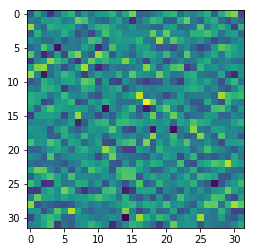

In [66]:
imshow(vmean[...].sum(axis=-1))

------
[6.92652463 6.93060831 6.91923461] [ 6.03781332 -9.37796744 -0.33308923]
[7.29609648 7.30182701 7.2838495 ] [  6.33869706 -12.69140142  -4.08777871]
[7.1769153  7.1841839  7.16220716] [  3.74089167 -10.0206726   -2.8812157 ]
[7.19736737 7.20514622 7.18326842] [  4.47698217 -10.07783709  -2.99050095]
[7.20729759 7.21425538 7.19270873] [ 4.03904091 -9.49481548 -2.84567331]
[7.2247013  7.23151258 7.20973241] [ 4.09825263 -9.36113561 -2.59380095]
[7.23862206 7.24557298 7.22352535] [ 4.09634949 -9.2057102  -2.44068745]
[7.25218121 7.2592226  7.2369077 ] [ 4.13818718 -9.17051132 -2.32399745]
[7.26451818 7.27159877 7.24903625] [ 4.14706243 -9.14736891 -2.26597132]
[7.27606886 7.28317592 7.26026073] [ 4.13402017 -9.12537862 -2.20831188]
[7.28680967 7.29393277 7.27061578] [ 4.12621915 -9.09049281 -2.16383454]
[7.29687009 7.30403044 7.28030282] [ 4.14130166 -9.04770472 -2.1326345 ]
[7.30634234 7.31357045 7.28944094] [ 4.17739382 -9.00603583 -2.14087457]
[7.30634234 7.31357045 7.28944094]


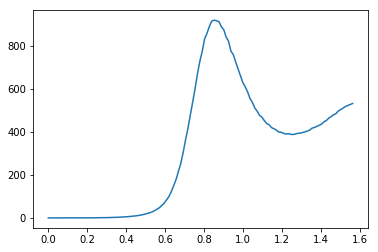

In [53]:
print('------')
state = test_solver(numpy.linspace(0.0, numpy.pi * 2 * (3 + 0.25), int(4 * (3 + 0.25) + 1 + 0.5)), B=2, usetree=False)
r = FFTPower(state.to_catalog(attrs={'BoxSize' :  state.pm.BoxSize}), mode='1d', Nmesh=256)
plot(r.power['k'], r.power['power'])
print(state.S.std(axis=0))
print('------')


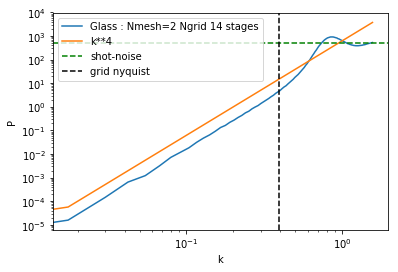

In [42]:
plot(r.power['k'], r.power['power'], label='Glass : Nmesh=2 Ngrid 14 stages')
plot(r.power['k'], r.power['k'] ** 4 * r.power.sel(method='nearest', k=[1.])['power'].real, label='k**4')
axhline(1  / (pm.Nmesh / pm.BoxSize).prod(), label='shot-noise', ls='--', color='green')
axvline(2 * pi / pm.BoxSize[0] * pm.Nmesh[0] / 2, label='grid nyquist', ls='--', color='k')
yscale('log')
xscale('log')
xlabel('k')
ylabel('P')
legend()

In [2]:
plot(state.X[:, 0][::1000], state.X[:, 1][::1000], '.')

NameError: name 'plot' is not defined

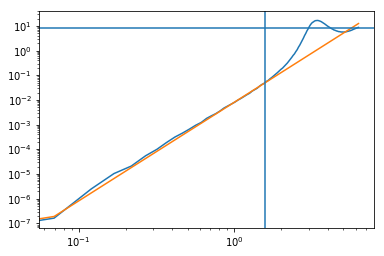

In [138]:
plot(r.power['k'], r.power['power'])
plot(r.power['k'], r.power['k'] ** 4 * r.power.sel(method='nearest', k=[1.])['power'].real)
axhline(1  / (pm.Nmesh / pm.BoxSize).prod())
axvline(2 * pi / pm.BoxSize[0] * pm.Nmesh[0] / 2)
yscale('log')
xscale('log')

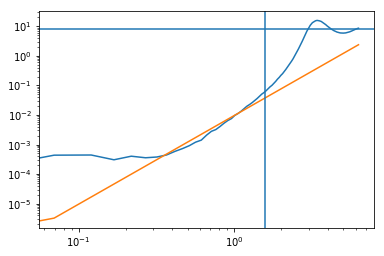

In [126]:
plot(r.power['k'], r.power['power'])
plot(r.power['k'], r.power['k'] ** 3 * r.power.sel(method='nearest', k=[1.])['power'].real)
axhline(1  / (pm.Nmesh / pm.BoxSize).prod())
axvline(2 * pi / pm.BoxSize[0] * pm.Nmesh[0] / 2)
yscale('log')
xscale('log')

In [42]:
2 * pi / 128. * 32

1.5707963267948966

In [109]:
h, b, b = histogram2d(state.X[:, 0] % 128, state.X[:, 1] %128, bins=32)

(array([  1.,   8.,  23.,  92., 134., 309., 267., 110.,  63.,  17.]),
 array([17. , 19.6, 22.2, 24.8, 27.4, 30. , 32.6, 35.2, 37.8, 40.4, 43. ]),
 <a list of 10 Patch objects>)

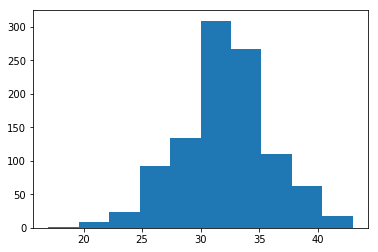

In [112]:
hist(h.flat)